In [1]:

from torchvision.utils import make_grid

from src.utils.dataset import dataset_to_dataloaders, show_class_name, get_class_example_image
from src.utils.visual import show_img, tensor_to_image, postprocess_image
from src.utils.training import fit, test_model
from src.models import download_model, HookedModel, load_model_weights_and_metrics
from src.deepdream import dream_process
from src.utils.config import RESNET18_FULL, RESNET18_TRANSFER, RESNET34_FULL, RESNET34_TRANSFER, RESNET50_FULL, RESNET50_TRANSFER, RESNET18_TEST, DEFAULT_OUTPUT_PATH
from src.utils.config import DREAM_CONFIG, BEETLE_DATASET, DEFAULT_TRAINING, DEFAULT_PLOTTING, JACKISET, MATHIAS_DATASET
from src.utils.config import get_new_config, DEFAULT_IMG_PATH, DEFAULT_VIDEO_PATH, Config
from src.utils.custom_types import *

# Import configuration dictionaries
Things work a bit differently now. Below we import configuration dictionaries that define our model, dataset and training.

These dictionaries are defined inside `src/utils/config.py`.

In [2]:
dataset_config =BEETLE_DATASET
model_config = RESNET34_FULL
training_config = DEFAULT_TRAINING
plot_config = DEFAULT_PLOTTING

In [3]:
config = Config()

# Apply transforms and get dataloaders

dataset sizes: {'train': 11021, 'val': 1378, 'test': 1378}


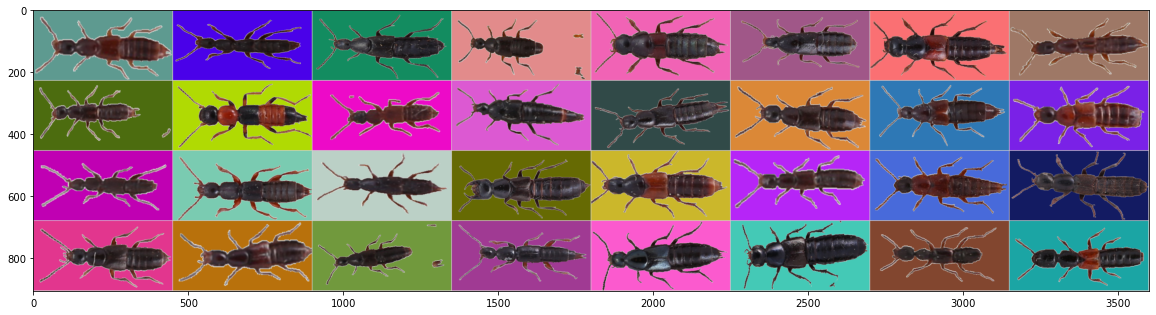

In [4]:
torch.cuda.empty_cache()

data_loaders, dataset_sizes = dataset_to_dataloaders(dataset_config)
iterable = iter(data_loaders['train'])
images, labels = next(iterable)
tensor_grid = make_grid(images, nrow=8)
image_grid = postprocess_image(tensor_to_image(tensor_grid))
show_img(image_grid, figsize=(20, 20))

# Define classification model

In [6]:
print('Loading {}'.format(model_config['model_architecture']))
model = download_model(model_config, dataset_config)

Loading resnet34


# Train and or load classification model

In [7]:
load = True

if load:
    metrics, model_config, dataset_config, training_config = load_model_weights_and_metrics(model, model_config)
    print(("test accuracy = %.2f %%" % training_config['train_info']['test_acc']))
else:
    metrics = fit(model, data_loaders, dataset_sizes,
                  model_config, training_config, dataset_config, plot_config, 
                  clear='notebook', plot=True, save_interval=1)
    acc = test_model(model, data_loaders['test'], training_config, model_config['device'])
_ = model.eval()

test accuracy = 90.71 %


# Expose layers

In [8]:
dreamnet = HookedModel(model)
_ = dreamnet.eval()
dreamnet.show_modules()

first layers,block 1,block 2,block 3,block 4,end layers
conv1,layer1,layer2,layer3,layer4,avgpool
bn1,layer1.0,layer2.0,layer3.0,layer4.0,fc
relu,layer1.0.conv1,layer2.0.conv1,layer3.0.conv1,layer4.0.conv1,
maxpool,layer1.0.bn1,layer2.0.bn1,layer3.0.bn1,layer4.0.bn1,
,layer1.0.relu,layer2.0.relu,layer3.0.relu,layer4.0.relu,
,layer1.0.conv2,layer2.0.conv2,layer3.0.conv2,layer4.0.conv2,
,layer1.0.bn2,layer2.0.bn2,layer3.0.bn2,layer4.0.bn2,
,layer1.1,layer2.0.downsample,layer3.0.downsample,layer4.0.downsample,
,layer1.1.conv1,layer2.0.downsample.0,layer3.0.downsample.0,layer4.0.downsample.0,
,layer1.1.bn1,layer2.0.downsample.1,layer3.0.downsample.1,layer4.0.downsample.1,


# Lets dream!

## Choose image

You can see what a specific class's name is with the function below.

In [9]:
show_class_name(0, dataset_config)

class 0: ./data/beetles/images/achenium_humile


This one takes a class label and returns an image instead.

Class path/name: ./data/beetles/images/achenium_humile


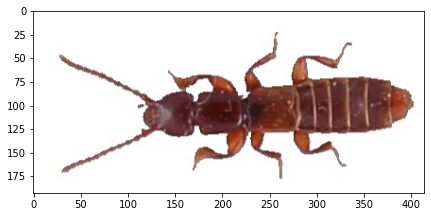

In [10]:
img = get_class_example_image(0, dataset_config)
show_img(img)

## Choose parameters and apply method

`out_info` is now a dictionary, and you can target modules in the model in a multitude of ways.

`{'fc': None}`      targets the entire `fc` layer

`{'fc': 1}`         targets class `1` in the `fc` layer

`{'fc': [0,1,2]}`   targets classes `0`,`1`,`2` in the `fc` layer


The same counts for 2d modules, such as `conv1`:

`{'conv1': (5,5)}`          targets `(5,5)` in `conv1`

`{'conv1': [(5,5), (2,2)]}`  targets `(5,5)` and `(2,2)` in `conv1`

In [12]:
params = {
    'input_img_path': 'data/beetles/images/achenium_humile/_0189_0.jpg',
    'target_dict': {'fc': None},
    'num_iters': 50,
    'levels': 3,
    'ratio':1.5,
    #'lr': 0.2,
    #'smooth_const': 0,
    'noise': 'uniform',
    #'correlation' : 'gaussian',
    #'correlation_std' : 1,
    'target_shape': (200, 400),
    #'gauss_filter' : (7, 7, 5, 5),
    'show': True,
    'output_img_path': None,
    'video_path': None,
    'scale_type' : 'scale_space'
}
config.dream = get_new_config(params, DREAM_CONFIG)
output_images = dream_process(dreamnet, config)


Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\x90\x00\x00\x00\xc8\x08\x02\x00\x00\x00Iw \xb5\x…

/home/thorreign/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448278899/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
